# Сеть прямого распространения для классификации изображений с цифрами MNIST.
Датасет взят с платформы Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files # надо загрузить свой токен от kaggle(json файл)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samtakoi","key":"a67e8370327483f7a36bf8b25f74e62b"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Загружаем данные, разархивируем и разделяем на тренировочную и тестовую выборки.

In [ ]:
! kaggle datasets download -d playlist/mnistzip

Dataset URL: https://www.kaggle.com/datasets/playlist/mnistzip
License(s): unknown
 57% 33.0M/57.8M [00:00<00:00, 124MB/s] 
100% 57.8M/57.8M [00:00<00:00, 147MB/s]


In [ ]:
from IPython.core.display import clear_output
!unzip '/content/mnistzip.zip' -d '/content/mnist'
clear_output()

In [ ]:
datadir='/content/mnist/mnist_png/mnist_png'
traindir = datadir + '/train/'
testdir = datadir + '/valid/'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

Предобратываем данные, превращаем в тензоры и далее создаем загрузчики

In [ ]:
train_transform = T.Compose([T.Grayscale(), T.ToTensor()])
test_transform = T.Compose([T.Grayscale(),T.ToTensor()])

In [ ]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=test_transform)

In [ ]:
batch_size=32 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([32, 1, 28, 28])


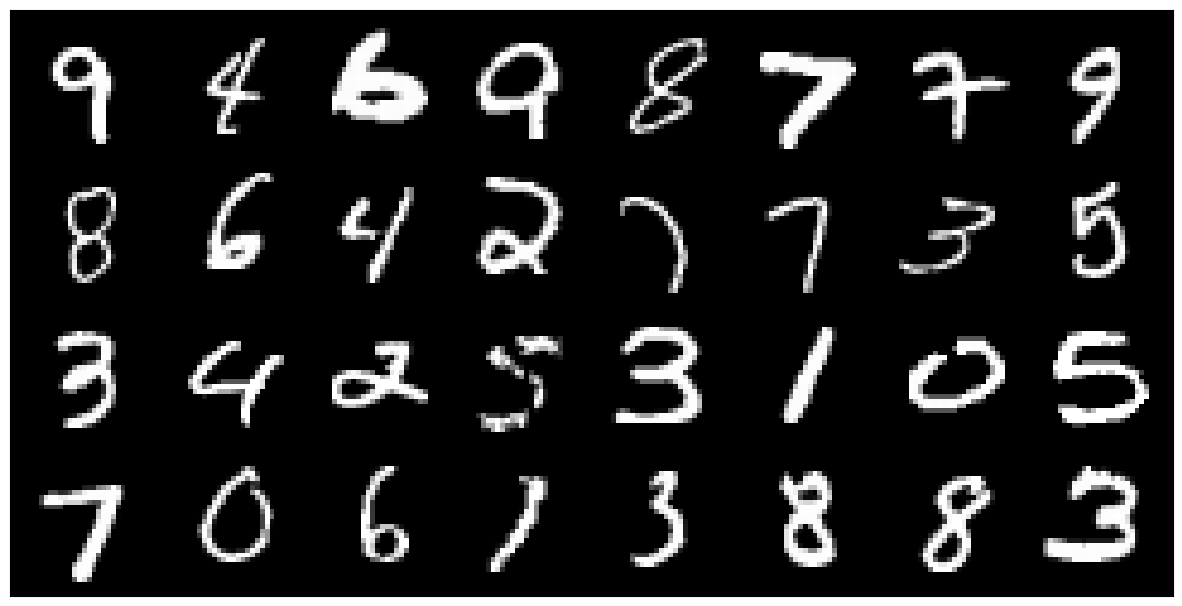

In [ ]:
show_batch(dataloaders['train'])

Создаем модель

In [ ]:
import torch.nn as nn

class Simple_MNIST_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,128)
    self.fc2 = nn.Linear(128,10)
    self.activation = nn.LeakyReLU(inplace=True)

  def forward(self,x): # прямой проход модели
    x = x.view(-1,28*28) # распрямляем изображение в вектор
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    return x

In [ ]:
model=Simple_MNIST_NN()
model.to(device)

Simple_MNIST_NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [ ]:
! pip install torchinfo

Посмотрим повнимательнее на то, как выглядит наша модель, и сколько всего будет параметров

In [ ]:
from torchinfo import summary
summary(model,input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Simple_MNIST_NN                          [1, 10]                   --
├─Linear: 1-1                            [1, 128]                  100,480
├─LeakyReLU: 1-2                         [1, 128]                  --
├─Linear: 1-3                            [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

Задаем функцию ошибки а алгоритм оптимизации, куда же без них =)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.5 MB/s eta 0:00:00


Цикл обучения построим с помощью библиотеки Ignite

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=10)}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

Создадим декораторы для логирования промежуточных результатов тренировки и тестирования междус эпохами. А так же вывод матрицы ошибок

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=2, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 95.82 Сред. ошибка: 0.14735
Результат валидации - Эпоха: 1  Сред. точность: 95.48 Сред. ошибка: 0.15092


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 97.14 Сред. ошибка: 0.09652
Результат валидации - Эпоха: 2  Сред. точность: 96.40 Сред. ошибка: 0.11231


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 97.95 Сред. ошибка: 0.06644
Результат валидации - Эпоха: 3  Сред. точность: 97.19 Сред. ошибка: 0.09242


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 98.21 Сред. ошибка: 0.05956
Результат валидации - Эпоха: 4  Сред. точность: 96.87 Сред. ошибка: 0.10169


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 98.76 Сред. ошибка: 0.04004
Результат валидации - Эпоха: 5  Сред. точность: 97.42 Сред. ошибка: 0.08010


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 99.01 Сред. ошибка: 0.03214
Результат валидации - Эпоха: 6  Сред. точность: 97.47 Сред. ошибка: 0.07650


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.35 Сред. ошибка: 0.02178
Результат валидации - Эпоха: 7  Сред. точность: 98.02 Сред. ошибка: 0.06778


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.55 Сред. ошибка: 0.01603
Результат валидации - Эпоха: 8  Сред. точность: 97.89 Сред. ошибка: 0.07232


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.56 Сред. ошибка: 0.01452
Результат валидации - Эпоха: 9  Сред. точность: 97.72 Сред. ошибка: 0.08137


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.55 Сред. ошибка: 0.01486
Результат валидации - Эпоха: 10  Сред. точность: 97.74 Сред. ошибка: 0.08186


State:
	iteration: 18750
	epoch: 10
	epoch_length: 1875
	max_epochs: 10
	output: 0.0016967864939942956
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

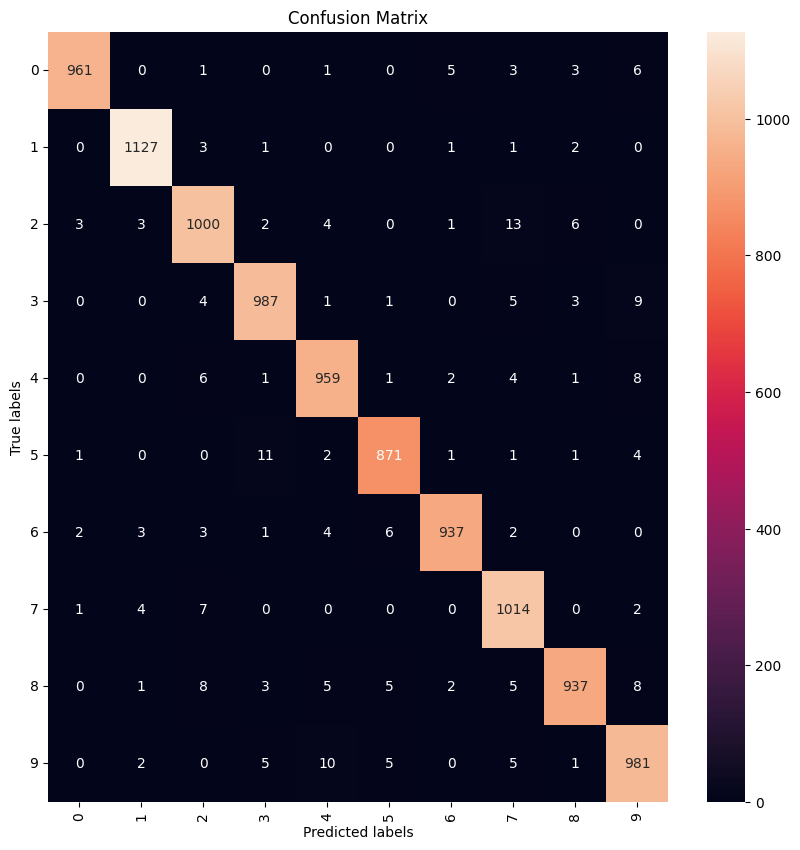

In [ ]:
trainer.run(train_loader, max_epochs=10)

Посмотрим на графиках, как вела себя модель по ходу обучения. (можно заметить, что после 6 эпохи началось переобучение)

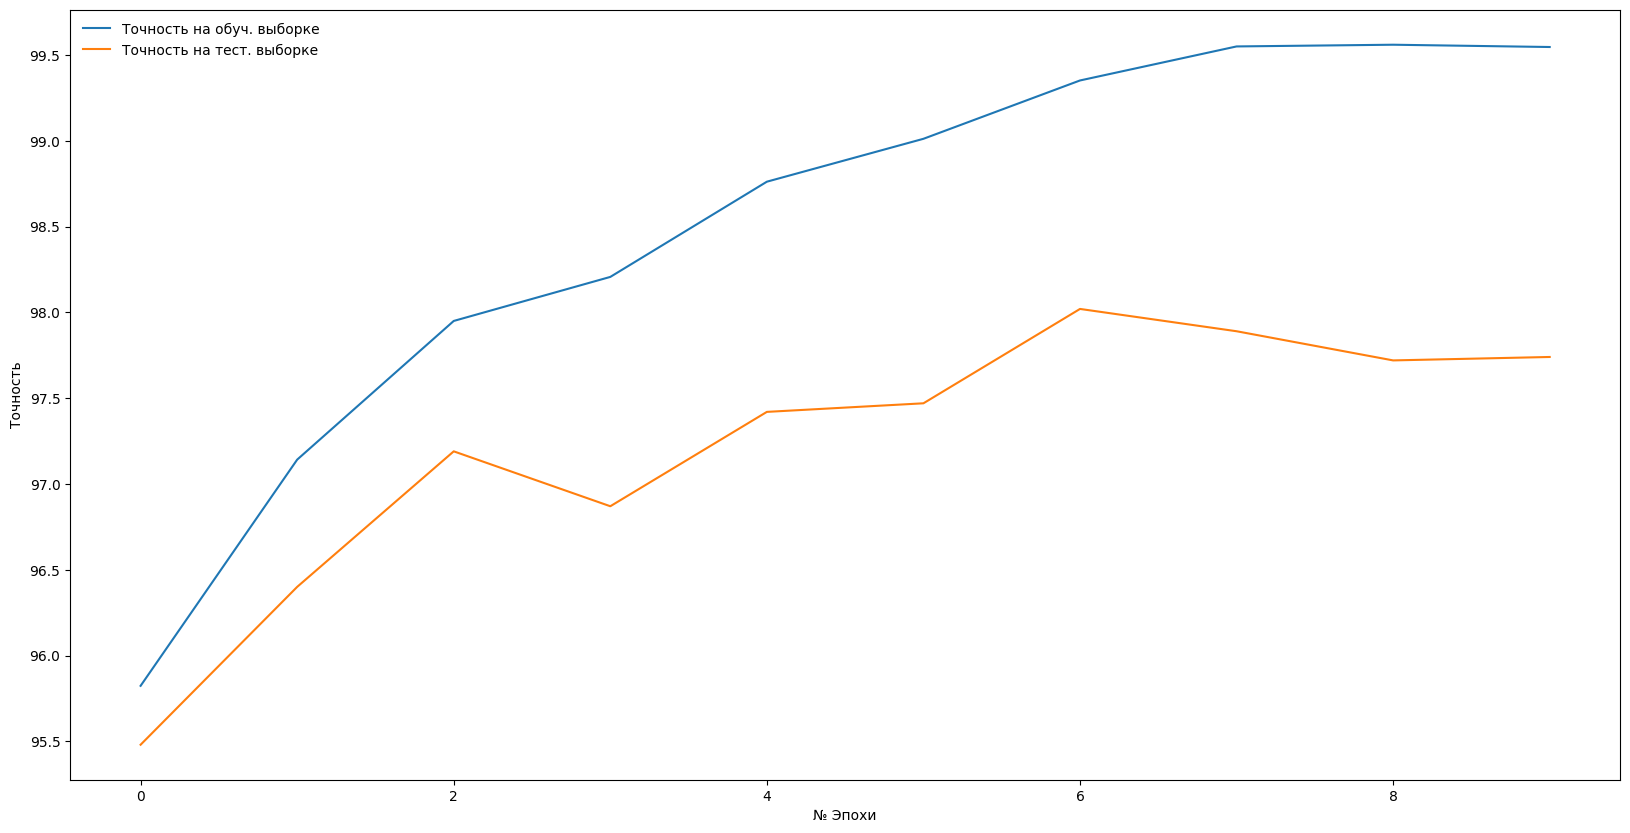

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

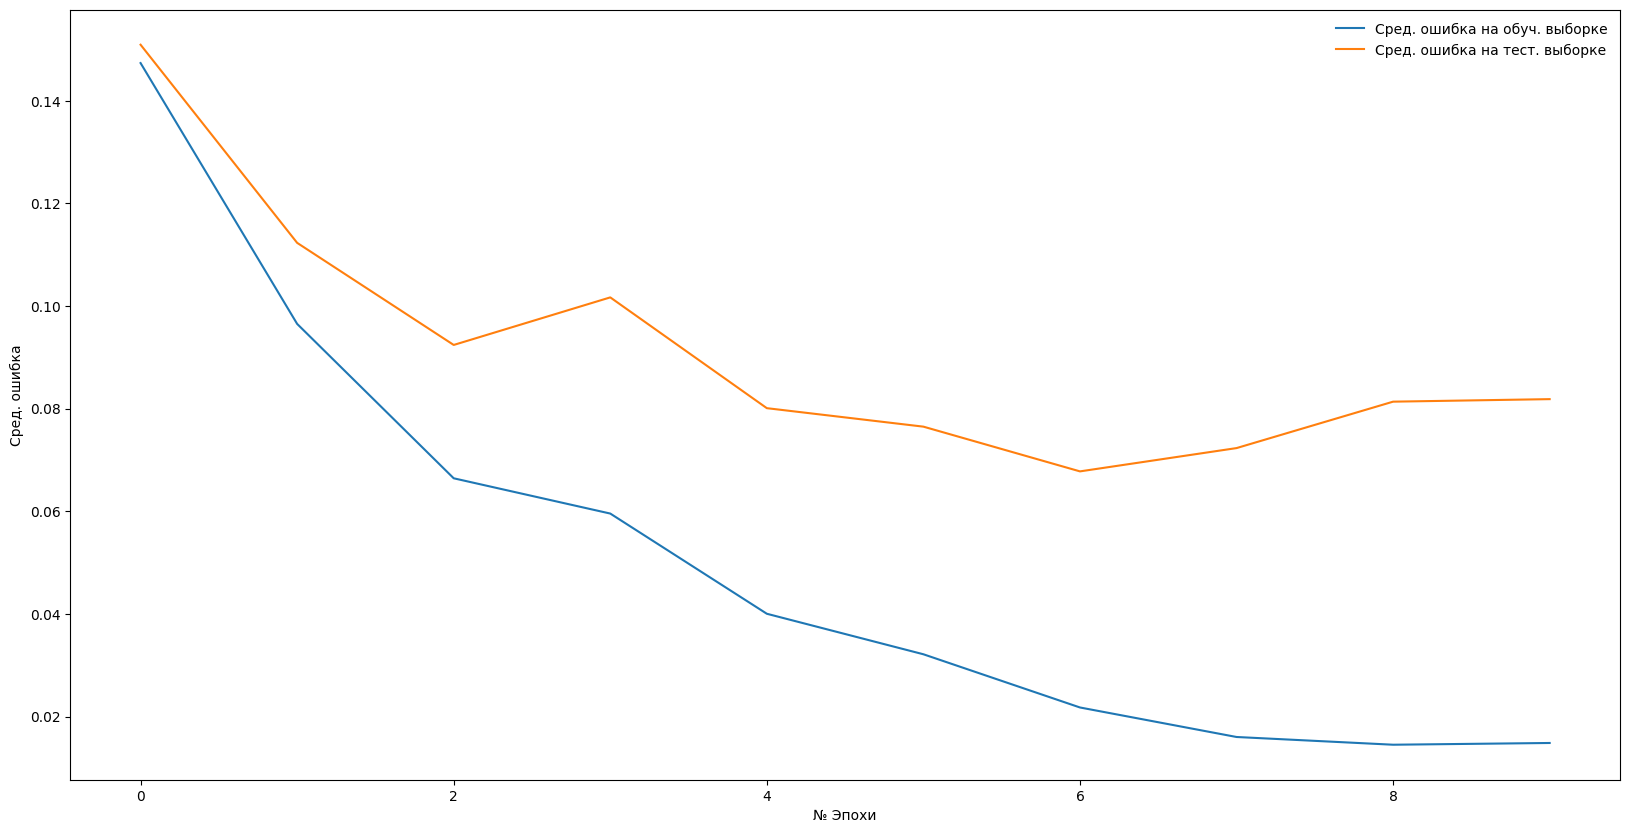

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


<ipython-input-35-02be131d5380>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))


In [ ]:
loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [ ]:
dataiter = iter(loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []
pred_arr = []
model.to("cpu")
for i in range(0,10000):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))

In [ ]:
misclass=[]
for i in range(len(labels_arr)-1):
    if labels_arr[i]!=pred_arr[i]:
        misclass.append(i)
len(misclass)

211

In [ ]:
classes=train_dataset.classes

Посмотрим на каких картинках модель дала ложные предсказания и какие

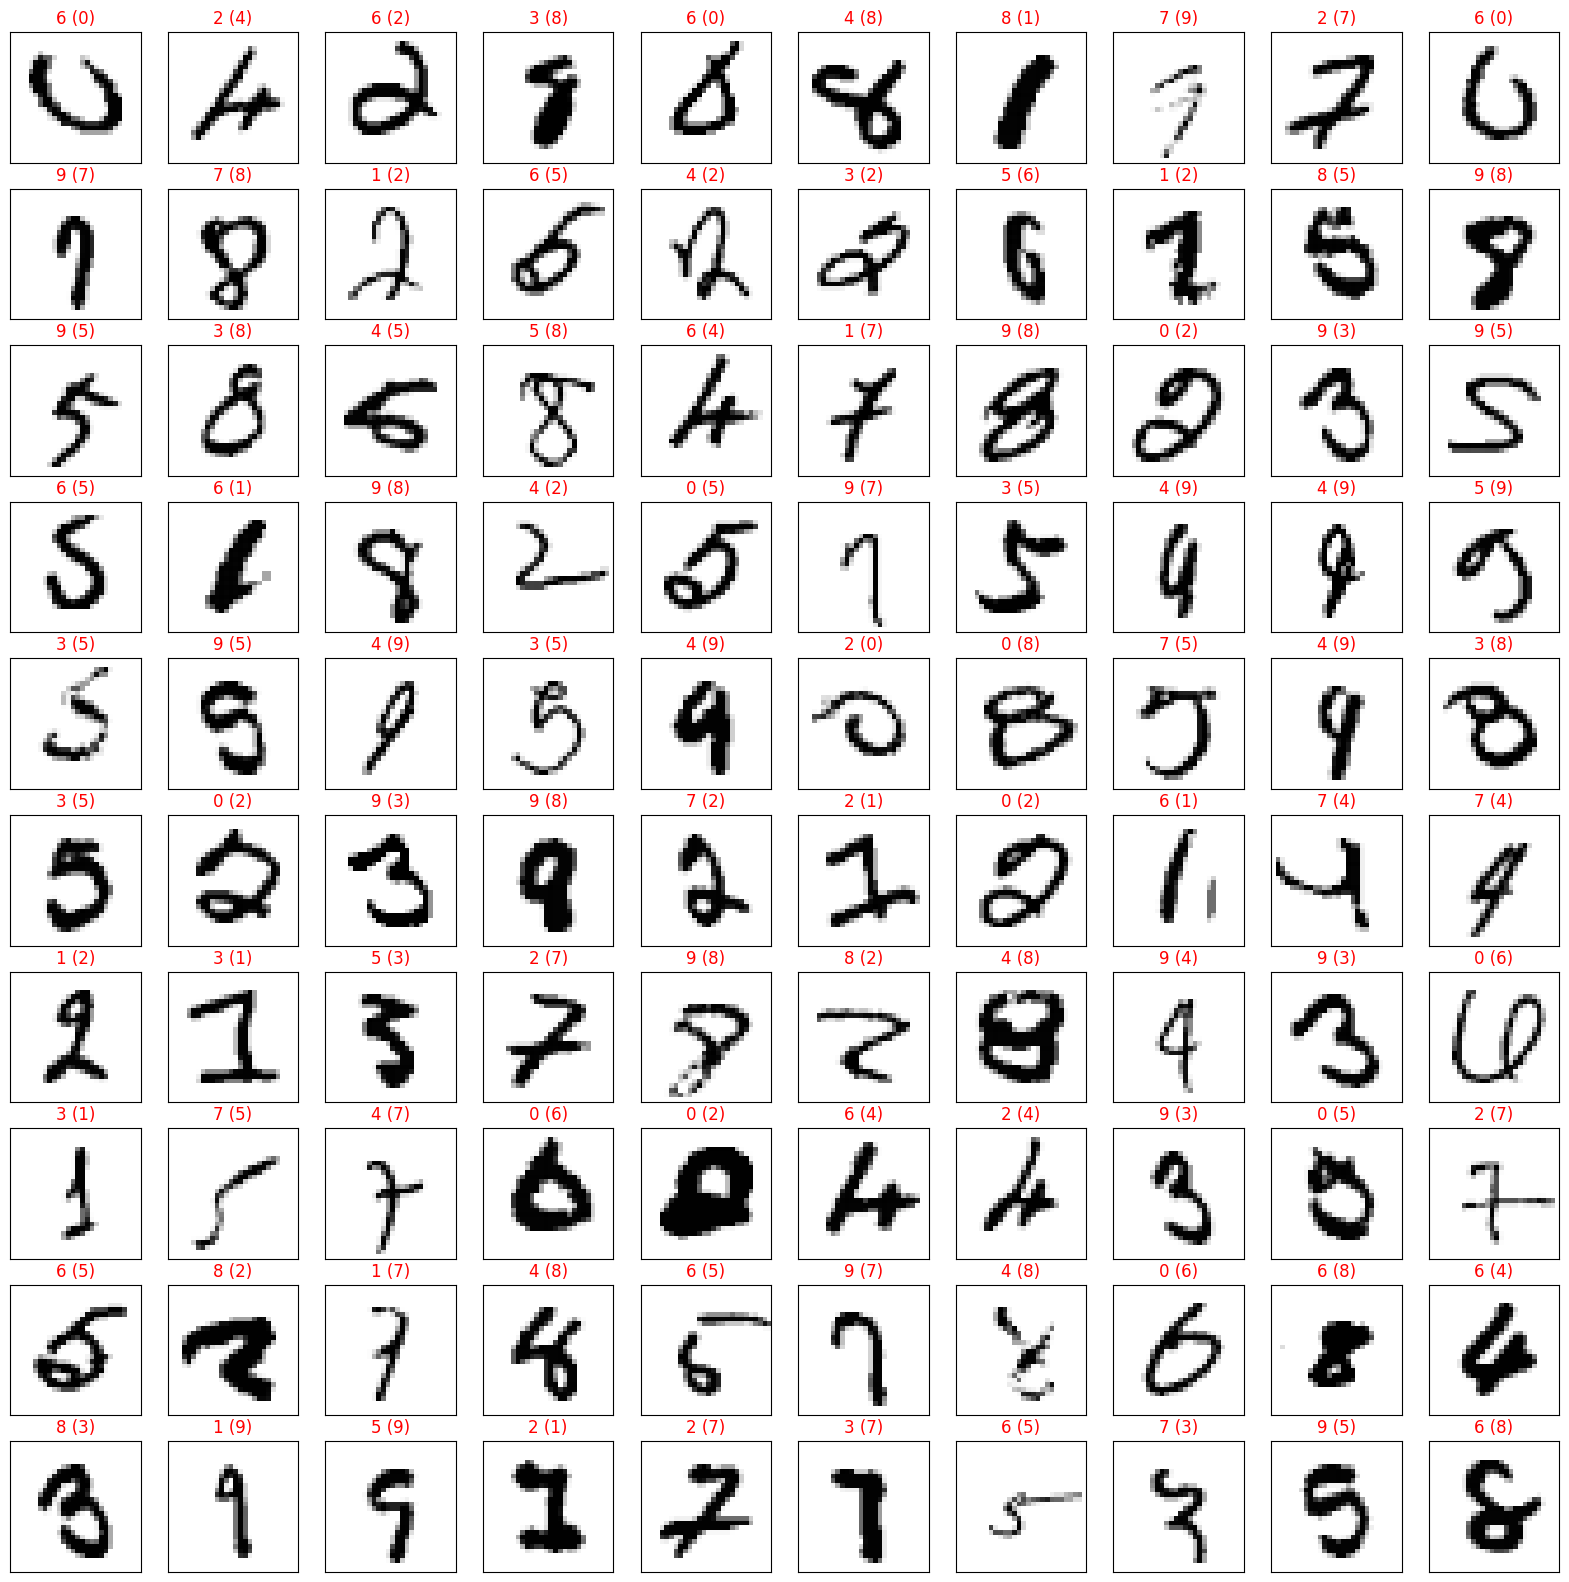

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(100):
    ind=misclass[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[ind].view(-1,28,28).to('cpu').numpy().squeeze(),cmap='Greys')
    ax.set_title("{} ({})".format(classes[pred_arr[ind]], classes[labels_arr[ind]]),
                 color=("green" if pred_arr[ind]==labels_arr[ind] else "red"))